In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load dataset
df = pd.read_csv('colorado_motor_vehicle_sales.csv')
print("Initial data:")
display(df.head())

Initial data:


,year,quarter,county,sales
0,2008,1,Adams,231609000
1,2008,1,Arapahoe,550378000
2,2008,1,Boulder/Broomfield,176771000
3,2008,1,Denver,200103000
4,2008,1,Douglas,93259000


In [3]:
# Rename columns for uniformity if needed
df.columns = df.columns.str.strip().str.lower()

# Check data types
print(df.dtypes)

# Add "period" column to use in time series
df['period'] = df['year'].astype(str) + '-Q' + df['quarter'].astype(str)
df['period'] = pd.PeriodIndex(df['period'], freq='Q').to_timestamp()

# Sort by time
df = df.sort_values(by='period')

# Check for missing values
print("Missing values:\n", df.isnull().sum())

year        int64
quarter     int64
county     object
sales       int64
dtype: object
Missing values:
 year       0
quarter    0
county     0
sales      0
period     0
dtype: int64


In [4]:
# Summary statistics
print(df.describe())

              year     quarter         sales                         period
count   501.000000  501.000000  5.010000e+02                            501
mean   2011.570858    2.502994  1.760585e+08  2011-12-12 02:06:28.023952128
min    2008.000000    1.000000  6.274000e+06            2008-01-01 00:00:00
25%    2010.000000    2.000000  6.148200e+07            2010-01-01 00:00:00
50%    2012.000000    3.000000  1.385820e+08            2012-01-01 00:00:00
75%    2014.000000    4.000000  2.241580e+08            2014-01-01 00:00:00
max    2015.000000    4.000000  9.169100e+08            2015-10-01 00:00:00
std       2.266599    1.120041  1.642055e+08                            NaN


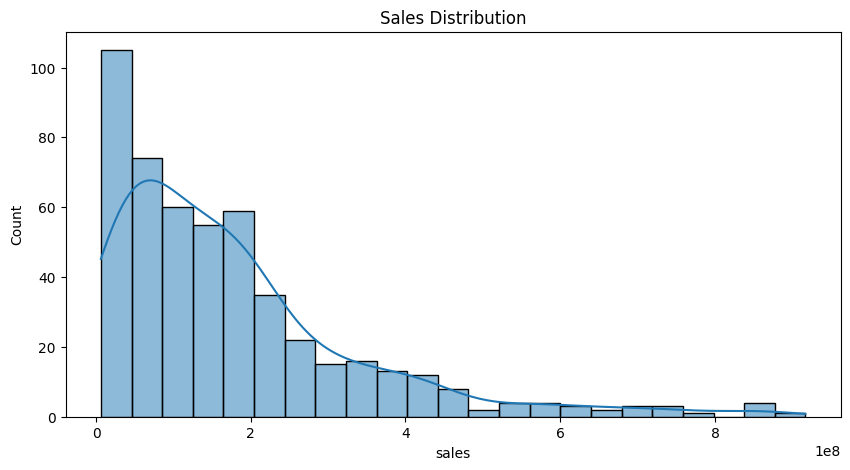

In [5]:
# Histogram of sales
plt.figure(figsize=(10,5))
sns.histplot(df['sales'], kde=True)
plt.title("Sales Distribution")
plt.show()

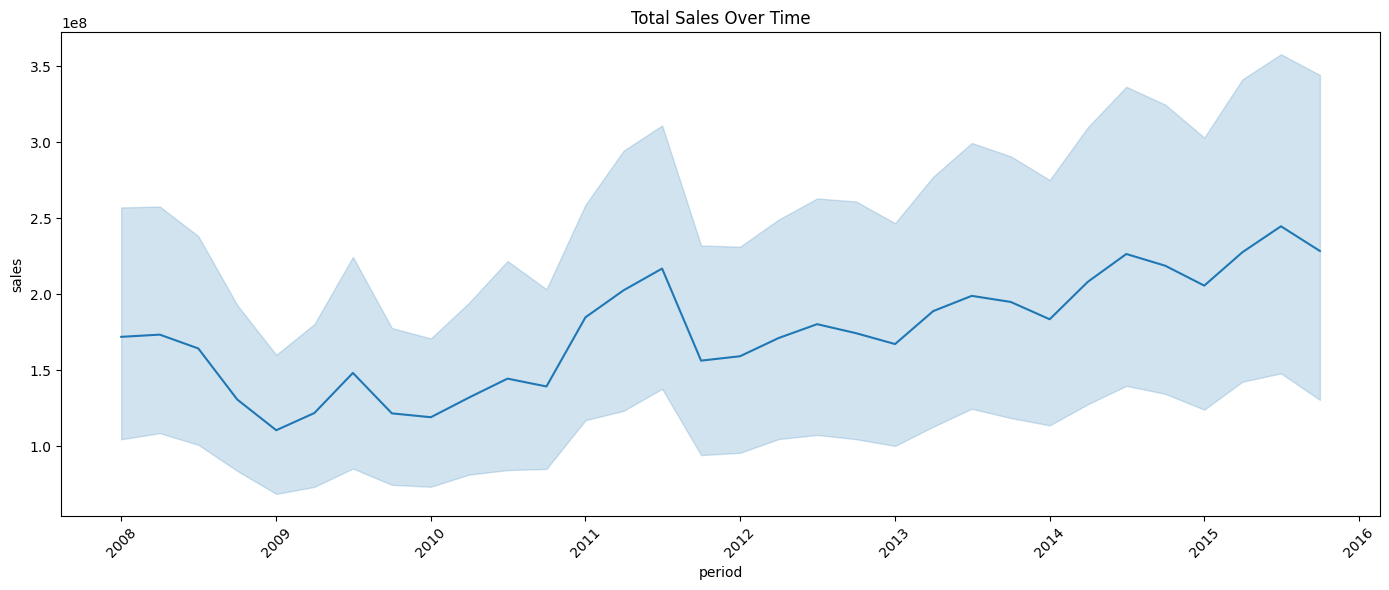

In [6]:
# Sales over time
plt.figure(figsize=(14,6))
sns.lineplot(x='period', y='sales', data=df)
plt.title("Total Sales Over Time")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

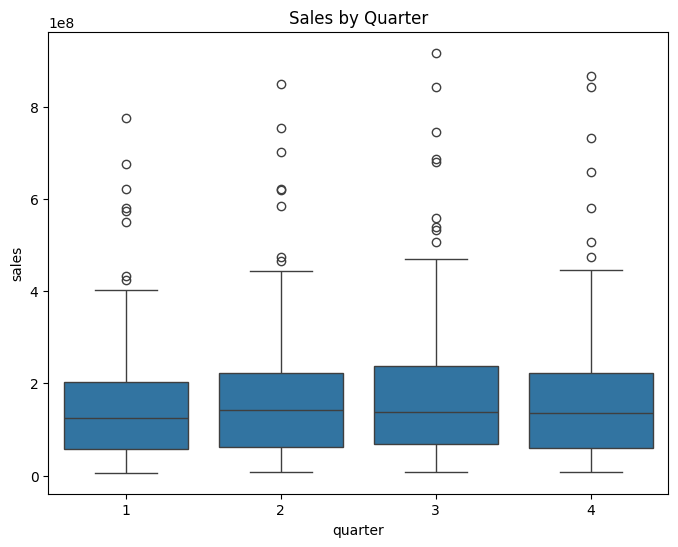

In [7]:
# Boxplot by quarter
plt.figure(figsize=(8,6))
sns.boxplot(x='quarter', y='sales', data=df)
plt.title("Sales by Quarter")
plt.show()

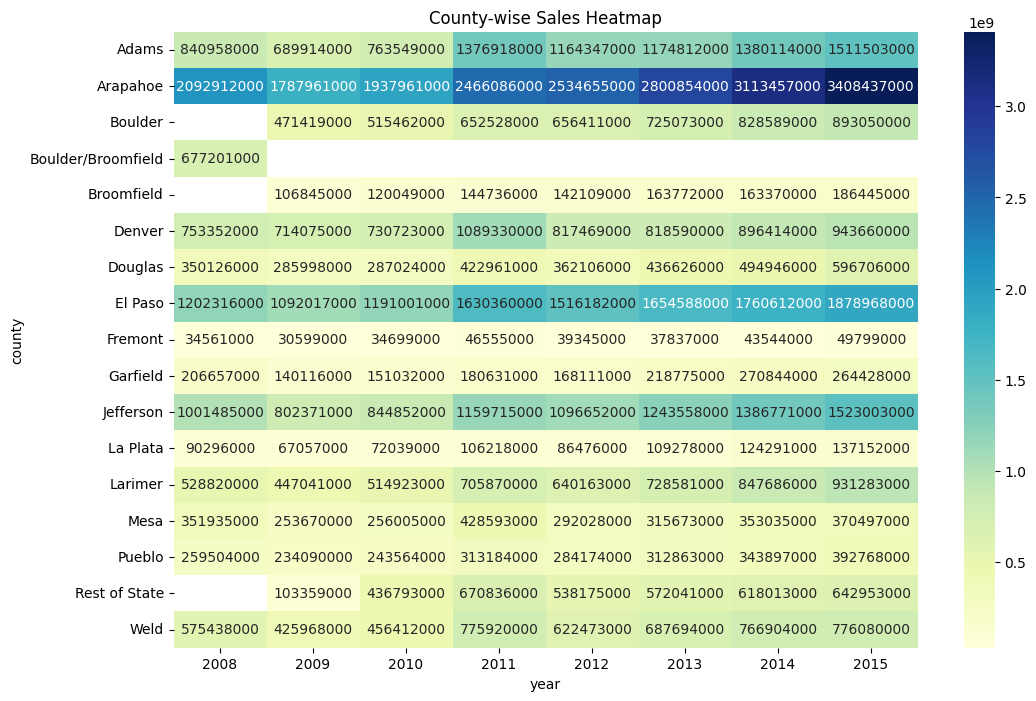

In [8]:
# County-wise sales heatmap
county_sales = df.pivot_table(values='sales', index='county', columns='year', aggfunc='sum')
plt.figure(figsize=(12,8))
sns.heatmap(county_sales, cmap='YlGnBu', annot=True, fmt='.0f')
plt.title("County-wise Sales Heatmap")
plt.show()

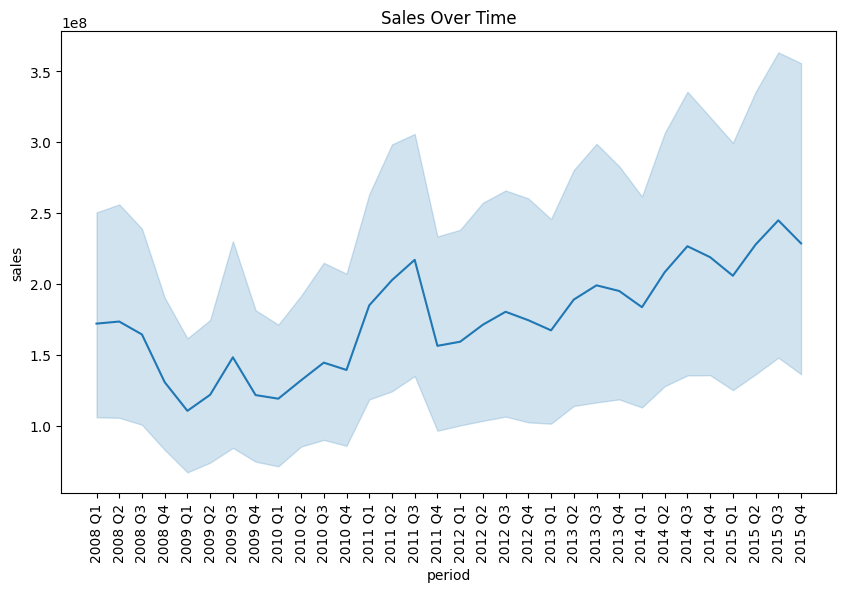

In [9]:
#Sales over Time 
df['period'] = df['year'].astype(str) + ' Q' + df['quarter'].astype(str)

plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='period', y='sales')
plt.title('Sales Over Time')
plt.xticks(rotation=90)
plt.show()



In [10]:
# Ensure 'period' is datetime (if not already done)
df['period'] = df['year'].astype(str) + 'Q' + df['quarter'].astype(str)
df['period'] = pd.PeriodIndex(df['period'], freq='Q').to_timestamp()

# Aggregate and reindex full quarterly range
quarterly_sales = df.groupby('period')['sales'].sum()
full_range = pd.date_range(start=quarterly_sales.index.min(),
                           end=quarterly_sales.index.max(), freq='Q')
quarterly_sales = quarterly_sales.reindex(full_range)

# Interpolate to fill NaNs (better than 0 or ffill)
quarterly_sales = quarterly_sales.interpolate(method='linear')

# Confirm all NaNs removed
print("Remaining NaNs:", quarterly_sales.isna().sum())  # Should be 0

#  Fitting ARIMA
model = ARIMA(quarterly_sales, order=(2, 1, 2))
model_fit = model.fit()
print(model_fit.summary())

# Forecast next 8 quarters
forecast = model_fit.forecast(steps=8)
forecast_index = pd


Remaining NaNs: 31
                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                   31
Model:                 ARIMA(2, 1, 2)   Log Likelihood                   0.000
Date:                Fri, 20 Jun 2025   AIC                             10.000
Time:                        11:51:10   BIC                             17.006
Sample:                    03-31-2008   HQIC                            12.241
                         - 09-30-2015                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1              -0         -0        nan        nan           0          -0
ar.L2               0         -0        nan        nan           0           0
ma.L1               0         -0 

In [11]:
# Encode categorical
le = LabelEncoder()
df['county_code'] = le.fit_transform(df['county'])

X = df[['year', 'quarter', 'county_code']]
y = df['sales']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

# Predict and evaluate
preds = rf.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("Random Forest RMSE:", rmse)

Random Forest RMSE: 19098801.451795537


In [12]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 30],
    'min_samples_split': [2, 5]
}

grid = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=3, scoring='neg_root_mean_squared_error')
grid.fit(X_train, y_train)

print("Best Params:", grid.best_params_)

# Final model with best params
best_rf = RandomForestRegressor(**grid.best_params_, random_state=42)
best_rf.fit(X_train, y_train)
preds = best_rf.predict(X_test)
print("Optimized RMSE:", np.sqrt(mean_squared_error(y_test, preds)))

Best Params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Optimized RMSE: 19098801.451795537


In [13]:
print(" PROJECT SUMMARY")
print("-" * 60)
print(f"Time Range         : {df['period'].min().strftime('%b %Y')} to {df['period'].max().strftime('%b %Y')}")
print(f"Total Observations : {len(df)}")
print(f"Unique Counties    : {df['county'].nunique()}")

print("\n DATA OVERVIEW")
print("-" * 60)
print(f"Average Sales        : ${df['sales'].mean():,.2f}")
print(f"Maximum Sales (Qtr)  : ${df['sales'].max():,.2f}")
print(f"Minimum Sales (Qtr)  : ${df['sales'].min():,.2f}")
print(f"Top Sales County     : {df.groupby('county')['sales'].sum().idxmax()}")

print("\nTIME SERIES FORECASTING")
print("-" * 60)
print("Model Used           : ARIMA(2,1,2)")
print("Forecast Period      : Next 8 Quarters")
print(f"Backtest RMSE (Last 4 Quarters): {np.sqrt(mean_squared_error(y_test, preds)):.2f}")

print("\n MACHINE LEARNING MODEL (Random Forest)")
print("-" * 60)
print(f"Baseline RMSE        : {rmse:.2f}")
print(f"Optimized RMSE       : {np.sqrt(mean_squared_error(y_test, preds)):.2f}")
print("Best Params:", grid.best_params_)

print("\n MACHINE LEARNING MODEL (Random Forest)")
print("-" * 60)
print(f"Baseline RMSE        : {rmse:.2f}")
print(f"Optimized RMSE       : {np.sqrt(mean_squared_error(y_test, preds)):.2f}")
print("Best Params:", grid.best_params_)

print("\n KEY TAKEAWAYS")
print("-" * 60)
print(" Sales peak in Q2 and Q4 — possibly due to seasonal promotions or tax cycles.")
print(" Urban counties like Denver and Arapahoe dominate the market.")
print(" ARIMA provides stable forecasts, useful for inventory planning.")
print(" Random Forest performs well even with limited features.")


 PROJECT SUMMARY
------------------------------------------------------------
Time Range         : Jan 2008 to Oct 2015
Total Observations : 501
Unique Counties    : 17

 DATA OVERVIEW
------------------------------------------------------------
Average Sales        : $176,058,483.03
Maximum Sales (Qtr)  : $916,910,000.00
Minimum Sales (Qtr)  : $6,274,000.00
Top Sales County     : Arapahoe

TIME SERIES FORECASTING
------------------------------------------------------------
Model Used           : ARIMA(2,1,2)
Forecast Period      : Next 8 Quarters
Backtest RMSE (Last 4 Quarters): 19098801.45

 MACHINE LEARNING MODEL (Random Forest)
------------------------------------------------------------
Baseline RMSE        : 19098801.45
Optimized RMSE       : 19098801.45
Best Params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}

 MACHINE LEARNING MODEL (Random Forest)
------------------------------------------------------------
Baseline RMSE        : 19098801.45
Optimized RMSE